In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from IPython.display import display
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import random
import torchinfo
from torchinfo import summary

### Data Prep

In [2]:
dataset = ImageFolder('data/training_set/training_set/')
dataset.classes

['cats', 'dogs']

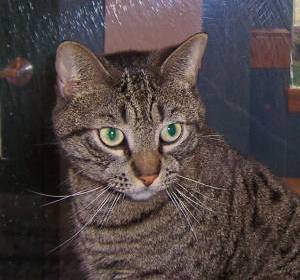

In [3]:
display(dataset[0][0])

In [4]:
len(dataset)

8005

In [5]:
transform = transforms.Compose([transforms.Resize((255,255) ),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor()])
train_dataset = ImageFolder('data/cats_dogs/train/', transform = transform)

In [6]:
train_dataset.class_to_idx

{'cats': 0, 'dogs': 1}

In [7]:
train_dataset[0][1] ## the class

0

Original shape: torch.Size([3, 255, 255]) -> [color_channels, height, width]
Image permute shape: torch.Size([255, 255, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'cats')

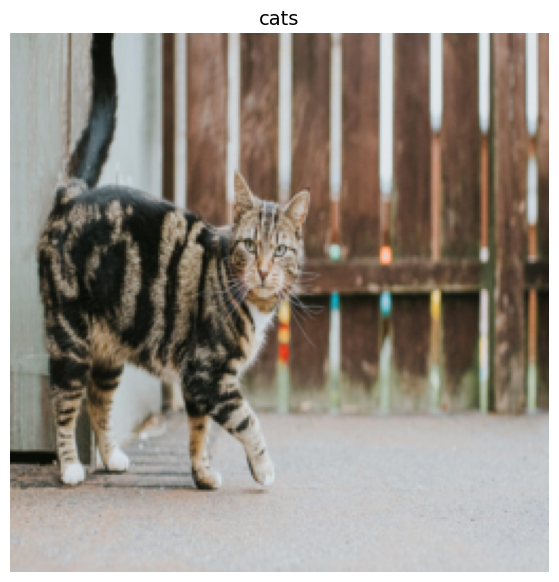

In [8]:
img, label = train_dataset[0][0], train_dataset[0][1]
class_names = train_dataset.classes
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [10]:
test_dataset = ImageFolder('data/test_set/test_set/', transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor()
]))

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

### Data Augmentation

In [12]:

IMAGE_WIDTH = 255
IMAGE_HEIGHT = 255
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),  # this one is a data augmentation technique
    transforms.ToTensor()])
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

In [15]:
train_data_aug = ImageFolder('data/training_set/training_set/', transform = train_transform)
test_data_aug = ImageFolder('data/test_set/test_set/', transform = test_transform)

In [16]:
train_data_aug
"data/cats_dogs_sample/train/"

Dataset ImageFolder
    Number of datapoints: 8005
    Root location: data/training_set/training_set/
    StandardTransform
Transform: Compose(
               Resize(size=(255, 255), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

In [17]:
torch.manual_seed(42)
train_dataloader_aug = torch.utils.data.DataLoader(train_data_aug, batch_size=32, shuffle=True, num_workers=2)
test_dataloader_aug = torch.utils.data.DataLoader(test_data_aug, batch_size=32, shuffle=False, num_workers=2)

### Arch design phase

In [18]:
class ConvBlock(nn.Module):
    def __init__(self,c_in_channels, c_out_channels, c_kernel_size, c_padding,
                 b_num_features,
                 m_kernal=None) -> None:
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=c_in_channels, out_channels=c_out_channels, kernel_size=c_kernel_size, padding=c_padding)
        self.r1 = nn.ReLU(inplace=True)
        self.b1 = nn.BatchNorm2d(b_num_features)
        self.m1 = nn.MaxPool2d(kernel_size=m_kernal)
    def forward(self,x):
        x = self.c1(x)
        x = self.r1(x)
        x = self.b1(x)
        x = self.m1(x)
        return x

In [19]:
class CatDogCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.conv_layer_1 = ConvBlock(3,64,3,1,64,2)
        self.conv_layer_2 = ConvBlock(64,512,3,1,512,2)
        self.conv_layer_3 = ConvBlock(512,512,3,1,512,2)
        self.flatten = nn.Flatten()
        self.linear_layer_1 =nn.Linear(512*3*3,out_features=num_classes)
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.flatten(x)
        x = self.linear_layer_1(x)
        return x

In [20]:
model = CatDogCNN(2)

### Sample inference

In [21]:
device = "cpu"
img_batch, label_batch = next(iter(train_dataloader_aug))
img_single , label_single= img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# Perform a forward pass
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 255, 255])

Output logits:
tensor([[-0.0117, -0.0095]])

Output prediction probabilities:
tensor([[0.4995, 0.5005]])

Output prediction label:
tensor([1])

Actual label:
1


In [22]:
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT]) 

Layer (type:depth-idx)                   Output Shape              Param #
CatDogCNN                                [1, 2]                    --
├─ConvBlock: 1-1                         [1, 64, 127, 127]         --
│    └─Conv2d: 2-1                       [1, 64, 255, 255]         1,792
│    └─ReLU: 2-2                         [1, 64, 255, 255]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 255, 255]         128
│    └─MaxPool2d: 2-4                    [1, 64, 127, 127]         --
├─ConvBlock: 1-2                         [1, 512, 63, 63]          --
│    └─Conv2d: 2-5                       [1, 512, 127, 127]        295,424
│    └─ReLU: 2-6                         [1, 512, 127, 127]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 127, 127]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 63, 63]          --
├─ConvBlock: 1-3                         [1, 512, 31, 31]          --
│    └─Conv2d: 2-9                       [1, 512, 63, 63]          2,359,

### setting up hyper parameters

In [23]:
device = "cpu"
model.to(device=device)

CatDogCNN(
  (conv_layer_1): ConvBlock(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (r1): ReLU(inplace=True)
    (b1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (m1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): ConvBlock(
    (c1): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (r1): ReLU(inplace=True)
    (b1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (m1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): ConvBlock(
    (c1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (r1): ReLU(inplace=True)
    (b1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (m1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)


In [100]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr =  0.0001)

### training

In [24]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        correct_predictions = (y_pred_class == y).sum().item()
        total_predictions = len(y_pred) 
        accuracy = correct_predictions / total_predictions
        train_acc += accuracy
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [25]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [26]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [27]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 25

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

from timeit import default_timer as timer 
start_time = timer()

model_results = train(model=model,
                      train_dataloader=train_dataloader_aug,
                      test_dataloader=test_dataloader_aug,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(),"model/cat_dog_full_cnn_25_epoch.pth")

### Prediction

In [ ]:
loaded_model = CatDogCNN(2)
loaded_model.load_state_dict(torch.load("model/cat_dog_full_cnn_34_epoch.pth"))

<All keys matched successfully>

In [ ]:
class ClassPredictor:
    def __init__(self,model,class_map) -> None:
        self.model = model
        self.class_map = class_map
    def preprocess(self,img_path):
        preprocess =transforms.Compose([
            transforms.Resize((255, 255)),
            transforms.ToTensor()
        ])
        image = Image.open(img_path).convert("RGB")
        image = preprocess(image)
        image = image.unsqueeze(0)
        return image
    def model_pred(self,img_tensor):
        self.model.eval()
        with torch.no_grad():
            output = self.model(img_tensor)
        _, pred_class = output.max(1)
        return self.class_map[pred_class.item()]
    def predict(self,img_path):
        img_tensor = self.preprocess(img_path=img_path)
        return self.model_pred(img_tensor=img_tensor)

In [ ]:
class_map = {
    0:"cat",
    1:"dog"
}
pred_obj = ClassPredictor(model=model,class_map=class_map)

In [ ]:
img_path = 'data/cats_dogs/test/cats/cat_158.jpg'
pred_obj.predict(img_path)

'cat'

In [ ]:
sns.lineplot(x = range(4), y = train_accuracies, color = "blue", label = "Training Accuracy")
sns.lineplot(x = range(4), y = test_accuracies, color = "orange", label = "Testing Accuracy")
plt.title("Train vs Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1,4,10), rotation = 45)
plt.yticks(label = range(1,4,15))
plt.legend()
plt.show()